In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import matplotlib.pyplot as plt
import os
from datetime import datetime
import random
import string
import multiprocessing as mp

In [2]:
seed = 161
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 3 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [3]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [4]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, mcart_val, mpole_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , mcart_s  , mpole_s  , length_s     = borders
    
    c_pos_indx  = np.where(c_pos_s  >= c_pos_val )[0][0].astype(int)
    c_vel_indx  = np.where(c_vel_s  >= c_vel_val )[0][0].astype(int)
    p_ang_indx  = np.where(p_ang_s  >= p_ang_val )[0][0].astype(int)
    p_vel_indx  = np.where(p_vel_s  >= p_vel_val )[0][0].astype(int)
    mcart_indx  = np.where(mcart_s  >= mcart_val )[0][0].astype(int)
    mpole_indx  = np.where(mpole_s  >= mpole_val )[0][0].astype(int)
    length_indx = np.where(length_s >= length_val)[0][0].astype(int)
    
    
    return [c_pos_indx, c_vel_indx, p_ang_indx, p_vel_indx, mcart_indx, mpole_indx, length_indx]

In [5]:
T_LR           = 1e-1
T_GAMMA        = 0.95
T_EPSILON      = 0.98

NO_OF_NODES    = 1
NO_OF_EPISODES = 50
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  1
Number of EPISODES per NODE 10


In [6]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 100000

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
#         print("Neural net")
#         print(self.eval_net)

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy()
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
        bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

        good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [8]:
iteration = 0
node_id = 0

In [9]:
# SET SEED
###############################################
my_seed = seed + node_id + iteration
random.seed(my_seed)
torch.manual_seed(my_seed)
np.random.seed(my_seed)
os.environ['PYTHONHASHSEED'] = str(my_seed)
my_env = env
my_env.seed(my_seed);
###############################################

In [10]:
# SET STATE VALUE BORDERS
###############################################
C_POS_MAX =  5
C_POS_MIN = -5

C_VEL_MAX =  5
C_VEL_MIN = -5

P_ANG_MAX =  1
P_ANG_MIN = -1

P_VEL_MAX =  5
P_VEL_MIN = -5

M_CART_MAX = 1.4
M_CART_MIN = 0.6

M_POLE_MAX = 0.14
M_POLE_MIN = 0.06

LENGTH_MAX = 0.7
LENGTH_MIN = 0.3
###############################################

In [11]:
# SET GRANULARITY
GRANULARITY = 10

In [12]:
# CREATE STATE TABLE BORDERS
###############################################
c_pos_s  = np.linspace(C_POS_MIN,  C_POS_MAX,  GRANULARITY)
c_vel_s  = np.linspace(C_VEL_MIN,  C_VEL_MAX,  GRANULARITY)
p_ang_s  = np.linspace(P_ANG_MIN,  P_ANG_MAX,  GRANULARITY)
p_vel_s  = np.linspace(P_VEL_MIN,  P_VEL_MAX,  GRANULARITY)
mcart_s  = np.linspace(M_CART_MIN, M_CART_MAX, GRANULARITY)
mpole_s  = np.linspace(M_POLE_MIN, M_POLE_MAX, GRANULARITY)
length_s = np.linspace(LENGTH_MIN, LENGTH_MAX, GRANULARITY)

borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, mcart_s, mpole_s, length_s]
###############################################

In [13]:
# CREATE STATE COMBINATIONS
###############################################

state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, M_CART_MIN, M_POLE_MIN, LENGTH_MIN],
                               [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, M_CART_MAX, M_POLE_MAX, LENGTH_MAX],
                                GRANULARITY)
###############################################

In [14]:
my_dqn = D3QN()
MODEL_FILENAME = './models/cartpole_v0-custom_xtra_21_40_48'
my_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
my_dqn.eval_net.eval()
my_Q_TABLE = my_dqn.get_qvals(state_combinations).reshape(GRANULARITY, GRANULARITY, GRANULARITY, GRANULARITY,
                                                          GRANULARITY, GRANULARITY, GRANULARITY, -1)

In [15]:
time_rec                = np.zeros(NO_OF_EPISODES)
# level_up_flag           = False
# PERFECT_RUN_COUNTER     = 10
# PERFECT_RUNS_HIGH_SCORE = 10
# level_up_metric         = 195
exp_rec      = np.empty(N_STATES * 2 + 2)
my_EPSILON   = T_EPSILON
my_LR        = T_LR

while True:
    i_episode = 0

    my_env.masscart = 1.0 * np.random.uniform(0.6,1.4)
    my_env.masspole = 0.1 * np.random.uniform(0.6,1.4)
    my_env.length   = 0.5 * np.random.uniform(0.6,1.4)

    xtra = [my_env.masscart, my_env.masspole, my_env.length]

    while i_episode < NO_OF_EPISODES:
        ep_exp_rec = np.empty(N_STATES * 2 + 2)
        time_steps = 0

        s = my_env.reset()
        s = np.append(s, xtra)

        while True:
            this_state = tuple(discretize(s, borders))

            time_steps += 1
            if np.random.uniform() > my_EPSILON:   # greedy
                a = np.random.randint(0, N_ACTIONS)
            else:
                a = my_Q_TABLE[this_state][:].argmax()

             # take action
            s_, r, done, info = my_env.step(a)
            s_ = np.append(s_, xtra)

            if done:
                r = -1
                if time_steps >= TIMESTEP_LIMIT:
                    r = 1

            experience = np.hstack((s,a,r,s_))
            exp_rec = np.vstack((exp_rec, experience))

            #discretize next_state
            next_state = tuple(discretize(s_, borders))

            # learn

            my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - 
                                                                     my_Q_TABLE[this_state][a])
            if done or time_steps >= TIMESTEP_LIMIT:
                time_rec[i_episode] = time_steps
                break
            s = s_

        i_episode += 1
    if i_episode >= NO_OF_EPISODES:
        i_episode = 0
        break

exp_rec = np.delete(exp_rec, 0, 0)
#     message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#     print(message)

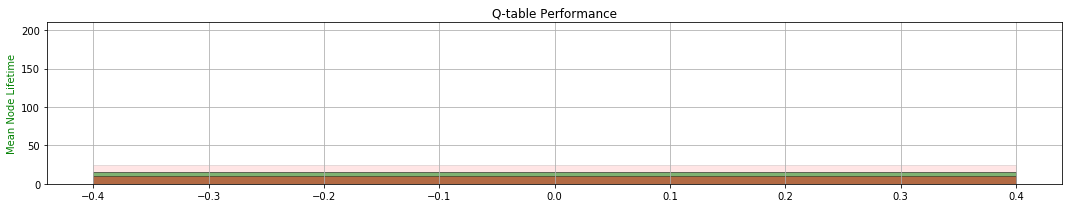

In [16]:
node_time_rec = time_rec
##################################################################

# PLOT EXPERIENCES
##################################################################
node_avg_time = node_time_rec.mean()
node_std_time = node_time_rec.std()
node_max_time = node_time_rec.max()
node_min_time = node_time_rec.min()

fig = plt.figure(figsize = (15,3))
ax2 = fig.add_subplot(1, 1, 1)
ax2.set_title("Q-table Performance")
ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
ax2.set_ylabel('Mean Node Lifetime',color = 'g')
ax2.set_ylim(0,TIMESTEP_LIMIT+10)
fig.tight_layout()
ax2.grid()
plt.show()
##################################################################